In [1]:
import pandas as pd

In [2]:
import os
import sys

# add path
if '../..' in sys.path:
    pass
else:
    sys.path.insert(0, '../..')
    

from loader.greenhouse_loader import GreenhouseLoader
from loader.power_industry_loader import PowerLoader

def load_co2_data():
    ghg_loader = GreenhouseLoader()
    cur_dir = os.getcwd()
    os.chdir('../../')
    ghg_loader.load()
    df_ghg = ghg_loader.get_data()
    os.chdir(cur_dir)
    return df_ghg

def load_power_industry():
    power_loader = PowerLoader()
    cur_dir = os.getcwd()
    os.chdir('../../')
    power_loader.load()
    df_power = power_loader.get_data()
    os.chdir(cur_dir)
    return df_power
    

In [3]:
co2_data = load_co2_data()
co2_df = co2_data['co2_country_sector']['Power Industry']
co2_df.index = pd.to_datetime(co2_df.index)
co2_df = co2_df.fillna(method='ffill')
co2_df = co2_df.rename(columns={'Spain and Andorra': 'Spain',
                                'France and Monaco': 'France',
                                'Italy, San Marino and the Holy See': 'Italy',
                                'Switzerland and Liechtenstein': 'Switzerland'})
co2_df = co2_df.resample('M').fillna('ffill')
co2_df.index = co2_df.index.map(lambda t: t.replace(day=1))

In [4]:
power_data = load_power_industry()
supply_df = power_data['supply']
supply_df = supply_df.drop(columns=['Montenegro', 'Serbia'])
print(supply_df.columns, '\n')
for country in supply_df.columns:
    print(co2_df[country].name)

Index(['Belgium', 'Bulgaria', 'Czechia', 'Denmark', 'Germany', 'Estonia',
       'Ireland', 'Greece', 'Spain', 'France', 'Croatia', 'Italy', 'Cyprus',
       'Latvia', 'Lithuania', 'Luxembourg', 'Hungary', 'Malta', 'Netherlands',
       'Austria', 'Poland', 'Portugal', 'Romania', 'Slovenia', 'Slovakia',
       'Finland', 'Sweden', 'United Kingdom', 'Norway', 'Switzerland',
       'North Macedonia', 'Turkey', 'Bosnia and Herzegovina'],
      dtype='object', name='') 

Belgium
Bulgaria
Czechia
Denmark
Germany
Estonia
Ireland
Greece
Spain
France
Croatia
Italy
Cyprus
Latvia
Lithuania
Luxembourg
Hungary
Malta
Netherlands
Austria
Poland
Portugal
Romania
Slovenia
Slovakia
Finland
Sweden
United Kingdom
Norway
Switzerland
North Macedonia
Turkey
Bosnia and Herzegovina


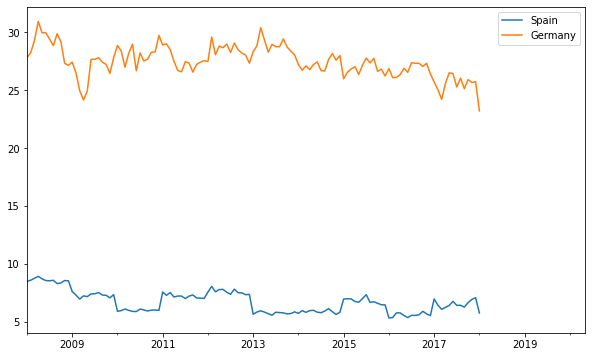

In [5]:
#for country in supply_df:
co2_monthly = pd.DataFrame(index=supply_df.index, columns=supply_df.columns)
years = list(supply_df.index.year.unique())
years = years[:-2]
for country in co2_monthly.columns:
    for year in years:  
        total = supply_df[f'{year}'][country].sum()
        weigths = supply_df[f'{year}'][country]/total
        total_co2 = co2_df[f'{year}'][country]
        co2_monthly.loc[f'{year}', country] = total_co2 * weigths
co2_monthly[['Spain', 'Germany']].plot(figsize=(10,6))

In [6]:
co2_df = co2_df.drop(columns=['EU'])

co2_df = co2_df.resample('M').fillna('ffill')
co2_df.index = co2_df.index.map(lambda t: t.replace(day=1))

co2_df = co2_df.loc['1997':, :]
co2_df = co2_df.sum(axis=1)
co2_df.name = 'CO2'
co2_df = co2_df.iloc[:-1]
co2_df = (co2_df/12)
co2_df = co2_df.astype(int)
co2_df

year
1997-01-01     720
1997-02-01     720
1997-03-01     720
1997-04-01     720
1997-05-01     720
              ... 
2017-08-01    1135
2017-09-01    1135
2017-10-01    1135
2017-11-01    1135
2017-12-01    1135
Name: CO2, Length: 252, dtype: int32

In [7]:
power_data = load_power_industry()

brent_df = power_data['brent']
brent_df = brent_df.loc['1997':, :]
brent_df = brent_df.rename(columns={'Price': 'Brent price'})
brent_forecast = brent_df['2018':]
brent_df = brent_df[:'2017']

gas_df = power_data['natural_gas']
gas_df = gas_df.rename(columns={'Price': 'Natural gas price'})
gas_forecast = gas_df['2018':]
gas_df = gas_df[:'2017']


data = pd.concat([brent_df, gas_df, co2_df], axis=1)
data.index.names = ['Date']
forecast = pd.concat([brent_forecast, gas_forecast], axis=1)

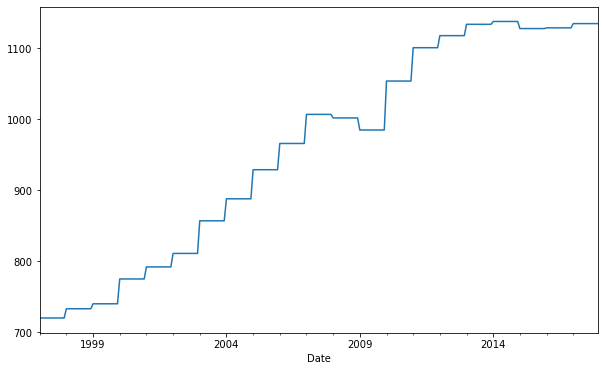

In [8]:
data['CO2'].plot(figsize=(10, 6))

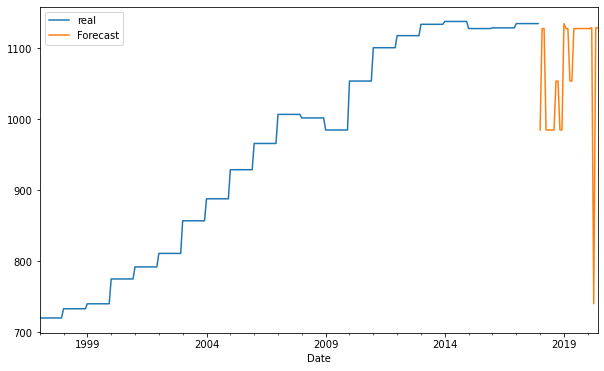

In [9]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression 
import matplotlib.pyplot as plt

X = data[['Brent price', 'Natural gas price']]
y = data['CO2']
X_test = forecast
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=350)



model = SVC(kernel='linear')
params = {'C': [0.1, 0.2, 0.5, 1, 2, 5]}

search = GridSearchCV(model, cv=KFold(5), n_jobs=-1,param_grid=params, scoring='neg_mean_squared_error')
search.fit(X, y)


   
estimator = search.best_estimator_
y_pred = estimator.predict(X_test)



'''
ax = fig.add_subplot(111)
ax.plot(forecast.index, y_pred)
ax.set_xticks'''

fc_series = pd.Series(y_pred, X_test.index)
aux_df = pd.DataFrame({'real': y, 'Forecast': fc_series})
ax = aux_df.plot(figsize=(10,6))
#ax.set_xlim(left = 2017)



In [10]:
total = fc_series['2020-1'].values[0]
vector = []
for month in range(1,7):
    aux = fc_series[f'2020-{month}'].values[0]
    vector.append(aux/total)
vector

[1.0,
 1.0,
 1.000886524822695,
 0.6560283687943262,
 1.000886524822695,
 1.000886524822695]